# Optimizing a Rate of Change (ROC) Trading Strategy with Bayesian Optimization: Backtest vs Buy & Hold

This notebook demonstrates how to build and optimize a Rate of Change (ROC) trading strategy using Bayesian Optimization. It includes a proper train-test split, backtests the strategy with virtual money, visualizes buy and sell signals, and compares the strategy’s performance against a simple buy-and-hold approach using real market data. Ideal for anyone interested in algorithmic trading and data-driven strategy tuning.

## Install and Import Libraries

In [90]:
%pip install yfinance bayesian-optimization matplotlib pandas ta tabulate --quiet

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\medium\articles\ROC_trading_strategy_optimization\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [91]:
import yfinance as yf
import matplotlib.pyplot as plt
from ta.momentum import ROCIndicator
from bayes_opt import BayesianOptimization
from tabulate import tabulate
plt.style.use('dark_background')

## Download Data

In [ ]:
# Load Bitcoin stock data
symbol = 'BTC-USD'
initial_cash = 1  # Initial cash for backtesting
data = yf.download(symbol, start='2020-01-01', end='2024-12-31')
data.columns = data.columns.get_level_values(0)
data = data[['Close']]
data.dropna(inplace=True)
data.head()

C:\Users\Brian\AppData\Local\Temp\ipykernel_8808\1653728570.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


Price,Close
Date,
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277
2020-01-04,7410.656738
2020-01-05,7411.317383


## Visualize Closing Price

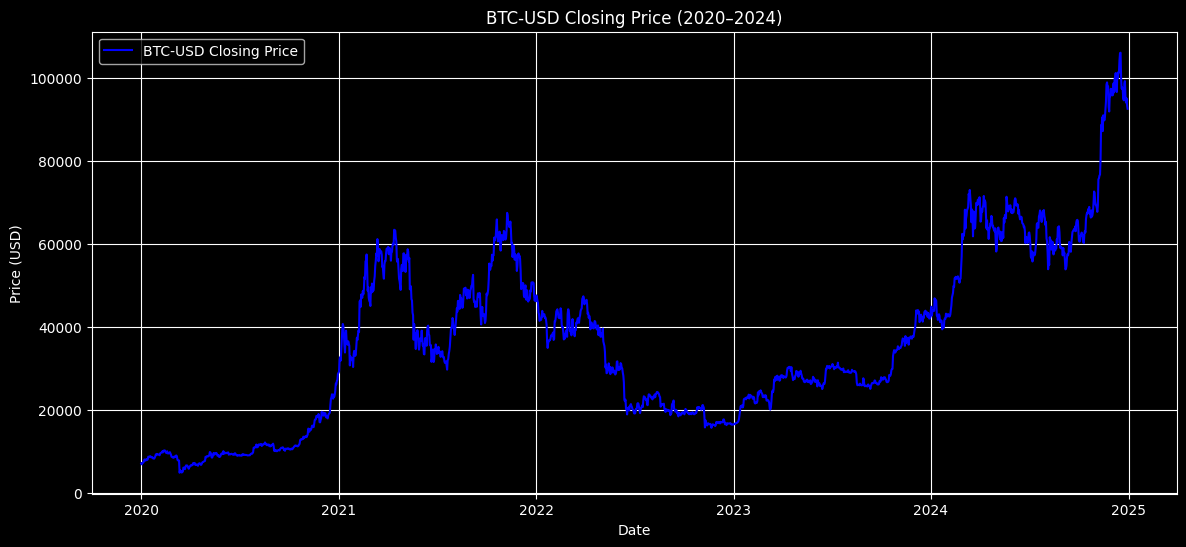

In [ ]:
# Visualize the closing price of the stock
plt.figure(figsize=(14,6))
plt.plot(data.index, data['Close'], label=f'{symbol} Closing Price', color='blue')
plt.title(f'{symbol} Closing Price (2020–2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.savefig('closing_price.png', dpi=300, bbox_inches='tight')
plt.show()

## Split Data into Train-Test Sets

In [94]:
# Train-test split (70% train, 30% test)
train_size = int(len(data) * 0.7)
train_data = data.iloc[:train_size].copy()
test_data = data.iloc[train_size:].copy()

print(f"Training from {train_data.index[0]} to {train_data.index[-1]}")
print(f"Testing from {test_data.index[0]} to {test_data.index[-1]}")

Training from 2020-01-01 00:00:00 to 2023-07-01 00:00:00
Testing from 2023-07-02 00:00:00 to 2024-12-30 00:00:00


## Backtest Function: Rate of Change Trading Strategy

In [95]:
def backtest_strategy(df, roc_window, buy_threshold, sell_threshold):
    df = df.copy()
    roc_window = int(roc_window)
    buy_threshold = float(buy_threshold)
    sell_threshold = float(sell_threshold)

    roc = ROCIndicator(close=df['Close'], window=roc_window)
    df['ROC'] = roc.roc()

    position = 0
    cash = initial_cash
    portfolio = []
    trades = 0
    buy_signals = []
    sell_signals = []

    for i in range(roc_window, len(df)):
        if df['ROC'].iloc[i] > buy_threshold and position == 0:
            position = cash / df['Close'].iloc[i]
            cash = 0
            buy_signals.append((df.index[i], df['Close'].iloc[i]))
            trades += 1
        elif df['ROC'].iloc[i] < sell_threshold and position > 0:
            cash = position * df['Close'].iloc[i]
            position = 0
            sell_signals.append((df.index[i], df['Close'].iloc[i]))
            trades += 1
        
        portfolio_value = cash + (position * df['Close'].iloc[i])
        portfolio.append(portfolio_value)

    final_value = cash + position * df['Close'].iloc[-1]
    return_percentage = (final_value - initial_cash) / initial_cash * 100

    return return_percentage, trades, buy_signals, sell_signals, portfolio

## Objective Function on Training Set

In [96]:
def objective(roc_window, buy_threshold, sell_threshold):
    returns, _, _, _, _ = backtest_strategy(train_data, roc_window, buy_threshold, sell_threshold)
    return returns

## Run Bayesian Optimization

In [97]:
pbounds = {
    'roc_window': (3, 30),
    'buy_threshold': (0.1, 10),
    'sell_threshold': (-10, -0.1)
}

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=20)
best_params = optimizer.max['params']
best_params

|   iter    |  target   | roc_wi... | buy_th... | sell_t... |
-------------------------------------------------------------
| 1         | 206.71866 | 13.112583 | 9.5120716 | -2.753259 |
| 2         | 180.63416 | 19.163779 | 1.6445845 | -8.455654 |
| 3         | 201.85777 | 4.5682575 | 8.6751438 | -4.048961 |
| 4         | 219.52980 | 22.117959 | 0.3037864 | -0.397892 |
| 5         | 529.55293 | 25.475951 | 2.2021571 | -8.199932 |
| 6         | 142.70577 | 19.520028 | 1.8527286 | -6.756215 |
| 7         | 512.03699 | 27.427557 | 2.3351120 | -8.853005 |
| 8         | 228.83641 | 25.861728 | 6.4559540 | -9.867867 |
| 9         | 672.57265 | 27.020347 | 0.1       | -6.975049 |
| 10        | 954.66279 | 30.0      | 0.1       | -3.869990 |
| 11        | 614.71958 | 30.0      | 2.3874743 | -0.1      |
| 12        | 781.54939 | 30.0      | 2.5331210 | -4.541751 |
| 13        | 568.44036 | 3.0       | 0.1       | -10.0     |
| 14        | 681.04620 | 30.0      | 0.1       | -5.746415 |
| 15    

{'roc_window': np.float64(27.943437909406587),
 'buy_threshold': np.float64(0.1),
 'sell_threshold': np.float64(-2.722477471437819)}

## Backtest on Testing Set with Best Parameters

In [98]:
best_roc = int(best_params['roc_window'])
best_buy = float(best_params['buy_threshold'])
best_sell = float(best_params['sell_threshold'])

returns, trades, buy_signals, sell_signals, portfolio = backtest_strategy(
    test_data, best_roc, best_buy, best_sell
)

print(f"Final Return on Test Set: {returns:.2f}%")
print(f"Number of Trades: {trades}")

Final Return on Test Set: 167.65%
Number of Trades: 24


## Compare Portfolio Performance: ROC Strategy vs. Buy & Hold

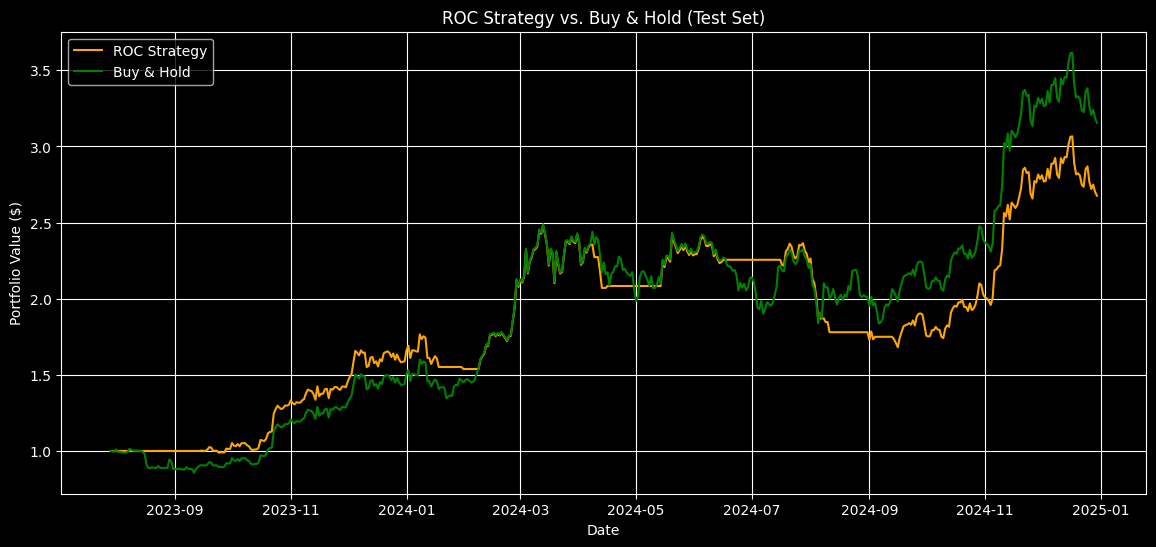

In [99]:
# Visualize portfolio value vs. buy-and-hold on the test set
df = test_data.copy()
df = df.iloc[best_roc:].copy()  # Skip rows lost due to ROC calculation

# Strategy Portfolio Value
df['Strategy'] = portfolio

# Buy-and-hold simulation
initial_price = df['Close'].iloc[0]
df['BuyHold'] = (df['Close'] / initial_price) * initial_cash

# Plot both
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Strategy'], label='ROC Strategy', color='orange')
plt.plot(df.index, df['BuyHold'], label='Buy & Hold', color='green')

plt.title('ROC Strategy vs. Buy & Hold (Test Set)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.savefig('portfolio_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualize Buy/Hold Signals on the Test Set

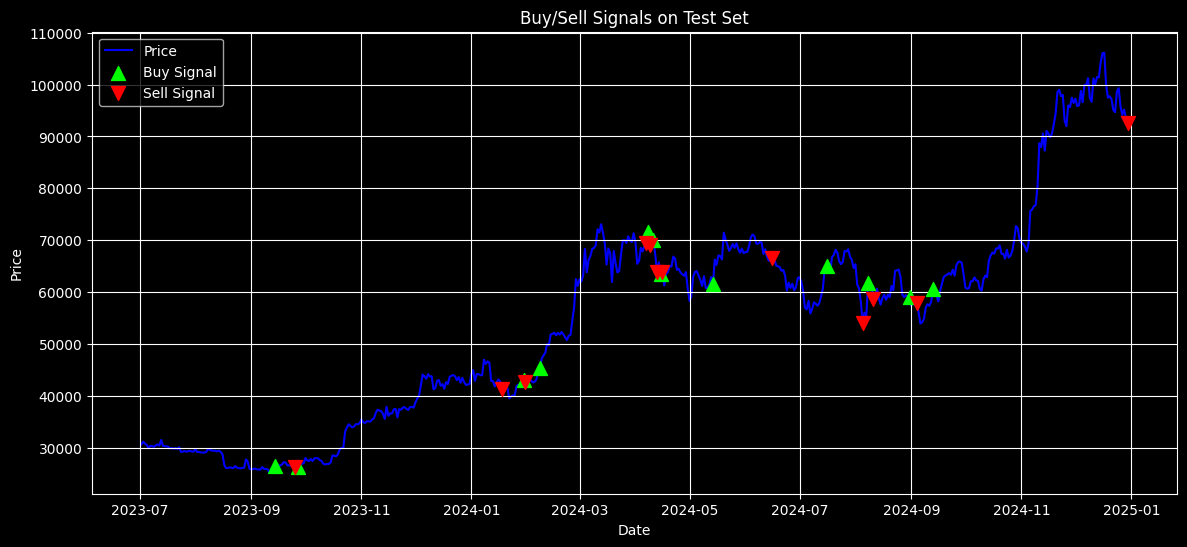

In [100]:
# Plot buy/sell signals on test set
plt.figure(figsize=(14,6))

# Plot the closing price first
plt.plot(test_data.index, test_data['Close'], label='Price', color='blue', zorder=1)

# Plot buy signals
for buy in buy_signals:
    plt.scatter(buy[0], buy[1], marker='^', color='lime', s=100, label='Buy Signal', zorder=2)

# Plot sell signals
for sell in sell_signals:
    plt.scatter(sell[0], sell[1], marker='v', color='red', s=100, label='Sell Signal', zorder=2)

# Only show each label once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('Buy/Sell Signals on Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.savefig('buy_sell_signals.png', dpi=300, bbox_inches='tight')
plt.show()

## Performance Summary: ROC Strategy vs. Buy & Hold

In [101]:
# Strategy evaluation
total_trades = len(buy_signals) + len(sell_signals)

if len(buy_signals) == len(sell_signals):
    successful_trades = sum(
        sell[1] > buy[1] for buy, sell in zip(buy_signals, sell_signals)
    )
    win_rate = f"{(successful_trades / len(sell_signals) * 100):.2f}%"
else:
    win_rate = 'Inconsistent buy/sell pairs'

test_df = test_data.copy().iloc[best_roc:].copy()  # align with portfolio calculation start
initial_price = test_df['Close'].iloc[0]
final_price = test_df['Close'].iloc[-1]

final_strategy_value = portfolio[-1]
final_bh_value = (final_price / initial_price) * initial_cash
bh_return_pct = (final_bh_value - initial_cash) / initial_cash * 100
strategy_return_pct = (final_strategy_value - initial_cash) / initial_cash * 100

summary = [
    ["Initial Cash", f"${initial_cash}", f"${initial_cash}"],
    ["Final Portfolio Value", f"${final_strategy_value:.2f}", f"${final_bh_value:.2f}"],
    ["Total Return (%)", f"{strategy_return_pct:.2f}%", f"{bh_return_pct:.2f}%"],
    ["Total Trades Executed", total_trades, "N/A"],
    ["Buy Trades", len(buy_signals), "N/A"],
    ["Sell Trades", len(sell_signals), "N/A"],
    ["Win Rate", win_rate, "N/A"]
]

print(tabulate(summary, headers=["Metric", "ROC Strategy", "Buy & Hold"], tablefmt="rounded_grid"))

╭───────────────────────┬────────────────┬──────────────╮
│ Metric                │ ROC Strategy   │ Buy & Hold   │
├───────────────────────┼────────────────┼──────────────┤
│ Initial Cash          │ $1             │ $1           │
├───────────────────────┼────────────────┼──────────────┤
│ Final Portfolio Value │ $2.68          │ $3.16        │
├───────────────────────┼────────────────┼──────────────┤
│ Total Return (%)      │ 167.65%        │ 215.58%      │
├───────────────────────┼────────────────┼──────────────┤
│ Total Trades Executed │ 24             │ N/A          │
├───────────────────────┼────────────────┼──────────────┤
│ Buy Trades            │ 12             │ N/A          │
├───────────────────────┼────────────────┼──────────────┤
│ Sell Trades           │ 12             │ N/A          │
├───────────────────────┼────────────────┼──────────────┤
│ Win Rate              │ 41.67%         │ N/A          │
╰───────────────────────┴────────────────┴──────────────╯
